In [1]:
import jax.numpy as np
# from jax.config import config; config.update("jax_enable_x64", True)
from jax import jacfwd, jacrev, hessian

import numpy as onp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import xara
import xaosim as xs
from xaosim.pupil import PHARO

from scipy.ndimage import fourier_shift

import morphine

import astropy.io.fits as fits 

from tqdm import tqdm

import pickle, gzip, glob

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

fftshift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")

import os

from jax.config import config; config.update("jax_enable_x64", True)


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
# ddir = os.path.abspath(os.path.dirname("__file__"))
ddir = '/Users/benjaminpope/code/xara/xara/'
# -------------------------------
# 1. create the KP info structure
# -------------------------------

# once saved, the kpi.gz structure can be directly reloaded when 
# creating a KPO instance, such as done in step #2.

a = xara.KPI(ddir+"hst.txt")
a.name = "HST - NIC1" #  # add a label to the template
a.save_to_file('./hst.kpi.gz')


Attempting to load file /Users/benjaminpope/code/xara/xara/hst.txt
332 distinct baselines were identified
10 first singular values for this array:
[46.79691 46.33162 35.01308 34.70472 20.0892  19.939   16.52361 16.40732
 13.82746 13.76126]

        Summary of properties for hst.txt
        ---------------------------------------------------------------
        - 112 sub-apertures
        - 332 distinct baselines
        - 276 Ker-phases (83.1 % target phase information recovery)
        -  56 Eig-phases (50.0 % wavefront information recovery)
        ---------------------------------------------------------------
        
KPI data successfully loaded


0

In [3]:
ls ../data/

hst/                   n8yj52020_mos.fits.gz  n8yj67020/
n8yj17010_mos.fits.gz  n8yj56010/             n9nk02010_mos.fits.gz
n8yj17020_mos.fits.gz  n8yj56020/             n9nk02020_mos.fits.gz
n8yj25010/             n8yj66010_mos.fits.gz  n9nk28010_mos.fits.gz
n8yj25020/             n8yj66020_mos.fits.gz  n9nk28020_mos.fits.gz
n8yj52010_mos.fits.gz  n8yj67010/


In [4]:
fits.getheader('HSTbinA.fits')

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   20                                                  
NAXIS2  =                  302                                                  
NAXIS3  =                  256                                                  
EXTEND  =                    T                                                  

In [5]:
def shift(im,dx,dy):
    input_ = onp.fft.fft2(im)
    result = fourier_shift(input_, shift=(dx,dy))
    return onp.real(onp.fft.ifft2(result))

def sim_binary(im,sep,th,con,pscale):
    sep_pix = sep/pscale
    th_rad = np.pi*th/180.
    dx, dy = sep_pix*np.cos(-th_rad), sep_pix*np.sin(-th_rad)
    shifted = shift(im,dx,dy)
    return im+shifted/con 

def preprocess_like(data,kpo):
    isz = 128
    xsz,ysz = data.shape
    wrad = 50
    pscale = 43.1                              # plate scale (mas)
    cwavel = kpo.CWAVEL  # central wavelength
    isz    = 128                               # chop image
    m2pix  = xara.core.mas2rad(pscale)*isz/cwavel   # Fourier scaling
    tdiam  = 2.4                               # telescope diameter (m)
    spix   = xara.core.rad2mas(cwavel/tdiam)/pscale # image sampling (pixels)

    (x0, y0) = xara.core.determine_origin(data, mask=None,
                                     algo="BCEN", verbose=False,
                                     wmin=2.0*spix)

    x1, y1 = int(x0-isz/2), int(y0-isz/2)
    img = data[y1:y1+isz, x1:x1+isz] # image is now (isz x isz)
    dy, dx   = (y0-ysz/2), (x0-xsz/2)

    sgmask = xara.core.super_gauss(isz, isz, isz/2, isz/2, wrad)
    (x0, y0) = xara.core.determine_origin(img, mask=sgmask,
                                     algo="BCEN", verbose=False,
                                     wmin=2.0*spix)

    img = xara.core.recenter(data,verbose=False)
    nx,ny = img.shape
    limsx = int(nx/2-64), int(nx/2+64)
    limsy = int(ny/2-64), int(ny/2+64)
    img = img[limsx[0]:limsx[1],limsy[0]:limsy[1]] # from 512x512 -> 128x128
    return img

In [6]:
# -------------------
# 2. load the dataset
# -------------------

# load the FITS frame, and extract the Kernel-phases using the
# HST KPI template calculated at the previous step. 
# Two data sets are provided:
# n8yj59010_mos.fits.gz and 'n8yj59020_mos.fits.gz
fname = 'HSTbinA.fits'

tgt_cube = fits.getdata(fname) # alpha Ophiuchi

band = 'H'
if band == 'J':
    fname_b = "../data/n8yj67020/n8yj67020_mos.fits" # pope 2013 - calibrator - J band
    fname_b = '../data/n8yj66020_mos.fits.gz' # pope 2013 - calibrator - 2M 1221
    fname_kerphi = 'hstmorphine_32bit_64pix_J.kpi.gz'

elif band == 'H':
    fname_b = "../data/n8yj67010/n8yj67010_mos.fits" # pope 2013 - calibrator - H band - 2M1705
#     fname_b = "../data/n8yj56010/n8yj56010_mos.fits.gz" # pope 2013 - calibrator - 2M 1105
#     fname_source = '../data/n8yj66010_mos.fits.gz' # pope 2013 - calibrator - 2M 1221 - has a faint binary
    fname_source = '../data/n8yj52010_mos.fits.gz' # pope 2013 - calibrator - 2M 0911 - clipped
    fname_source = '../data/n9nk02010_mos.fits.gz' # pope 2013 - calibrator - 2M 0228 - ok
#     fname_source = '../data/n9nk28010_mos.fits.gz' # pope 2013 - calibrator - 2M 1421

#     fname_b = '../data/n8yj17010_mos.fits.gz' # pope 2013 - calibrator - 2M 1731 - has a faint binary
    fname_kerphi = 'hstmorphine_32bit_64pix.kpi.gz'
    fname_kerphi = 'hstmorphine_32bit_64pix_H.kpi.gz'
    fname_kerphi = 'hstmorphine_32bit_96pix_H.kpi.gz'
#     fname_kerphi = 'hstmorphine_32bit_128pix_H.kpi.gz'
#     fname_kerphi = 'hstmorphine_64bit_128pix_H.kpi.gz'
#     fname_kerphi = 'hstmorphine_32bit_128pix_H.kpi.gz'
# fname = ddir+'/n8yj59010_mos.fits.gz' # frantz example

# fname_kerphi = './hst.kpi.gz'
# a = xara.KPO(fname_kerphi,offset=0.5)#xara.KPO(fname_kerphi,offset=0.5)
c = xara.KPO(fname_kerphi,offset=0.5)#xara.KPO(fname_kerphi,offset=0.5)

myf = gzip.open(fname_kerphi, "r")
stuff = pickle.load(myf)
myf.close()

c.M2PIX = xara.core.mas2rad(43.1) * 128 / 1.7057900000000002e-06
c.FF = stuff['dft']
b = c.copy()

dir_b = '../data/hst/cal/f170/*'

fnames_b = glob.glob(dir_b)
calibrators = []
otfs = []

b = c.copy()

for fb in fnames_b:
    if fname_source[8:16] in fb:
        continue
    try:
        b = c.copy()
    # b.extract_KPD(fname_b, wrad=50) # calibrator
        b.extract_KPD(fb,wrad=50)
        calibrators.append(b.KPDT[0][0])
        otf = np.abs(b.CVIS[0][0])
        otfs.append(otf/otf.max())
    except:
        print('failed on',fb)
calibrators = np.array(calibrators)
otfs = np.array(otfs)
pscale=b.PSCALE
wl = b.CWAVEL
print('Done calibrator')
cal = fits.getdata(fname_source).astype('float64')


Attempting to load file hstmorphine_32bit_96pix_H.kpi.gz
KPI data successfully loaded
File provided is not a fits file
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n9nk31010_mos.fits.gz, slice  1
failed on ../data/hst/cal/f170/n9nk31010_mos.fits.gz
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj20010_mos.fits.gz, slice  1
failed on ../data/hst/cal/f170/n8yj20010_mos.fits.gz
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj35010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj51010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj28010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj32010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8

The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n9nk04010_mos.fits.gz, slice  1
failed on ../data/hst/cal/f170/n9nk04010_mos.fits.gz
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj64010_mos.fits.gz, slice  1
failed on ../data/hst/cal/f170/n8yj64010_mos.fits.gz
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n9nk03010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj12010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj63010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj13010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n9nk17010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj62

In [7]:
# good_calibs = (onp.nanstd(calibrators,axis=1)<1)*(onp.nanstd(calibrators,axis=1)<0.02)*(onp.nanstd(otfs,axis=1)>0.1)
# calibrators = calibrators[good_calibs,:]
# otfs = otfs[good_calibs,:]
# print(calibrators.shape)

In [8]:
calibrators = calibrators[onp.nanstd(calibrators,axis=1)<1]
otfs = otfs[onp.nanstd(calibrators,axis=1)<1]

calibrators = calibrators[onp.nanstd(otfs,axis=1)>0.1]
otfs = otfs[onp.nanstd(otfs,axis=1)>0.1]


In [9]:
calibrators.shape

(43, 1467)

In [10]:
# calib  = np.median(np.array(calibrators),axis=0)
# calib = b.KPDT[0][0]
# coeffs = onp.linalg.lstsq(np.array(calibrators).T,a.KPDT[0][0], rcond=None)[0]
# calib = np.dot(coeffs,np.array(calibrators))

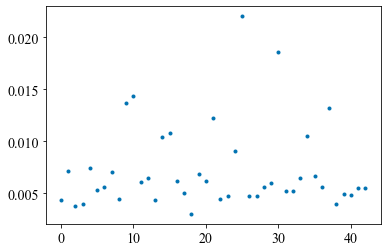

In [11]:
plt.plot(onp.nanstd(calibrators,axis=1),'.')

In [12]:
# dots = np.array([np.dot(cc,a.KPDT[0][0]) for cc in calibrators])

In [13]:
# plt.plot(dots,'.')

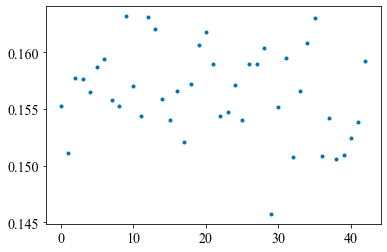

In [14]:
plt.plot(onp.nanstd(otfs,axis=1),'.')

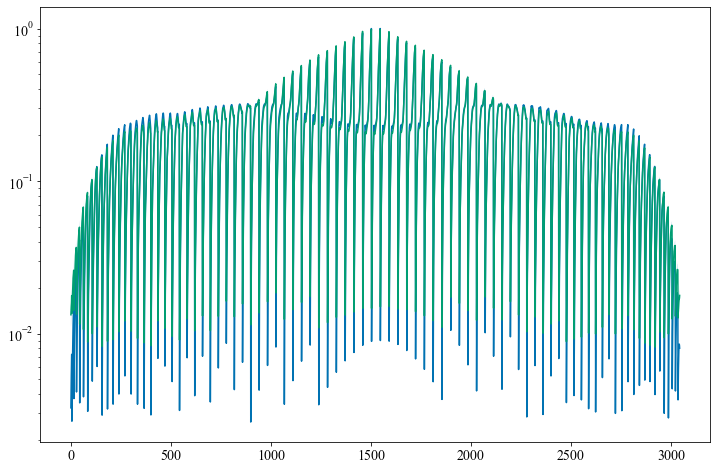

In [15]:
fig = plt.figure(figsize=(12.0,8.0))
plt.fill_between(np.arange(len(otfs[0,:])),np.median(otfs,axis=0)-np.std(otfs,axis=0),
                np.median(otfs,axis=0)+np.std(otfs,axis=0),alpha=0.2)
plt.plot(b.kpi.RED/b.kpi.RED.max())
plt.plot(np.mean(otfs,axis=0))

plt.yscale('log')

In [16]:
from sklearn.decomposition import PCA 

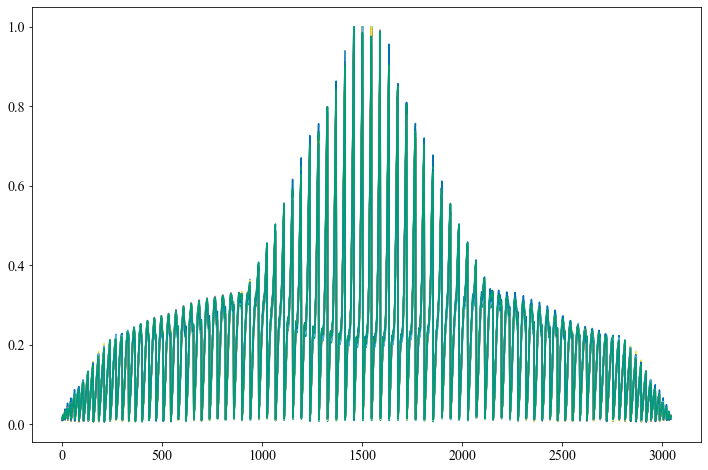

In [17]:
fig = plt.figure(figsize=(12.0,8.0))

for j in range(20):
    plt.plot(otfs[j,:],'-')

In [18]:
pca = PCA(n_components=5)
pca.fit(calibrators)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [19]:
pca.components_.shape

(5, 1467)

In [20]:
pca.explained_variance_ratio_

array([0.20527901, 0.13996189, 0.09301081, 0.07430021, 0.06524123])

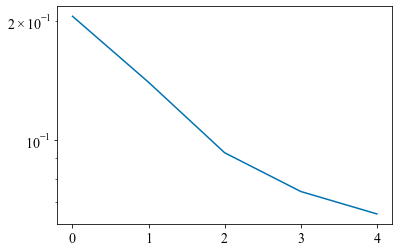

In [21]:
plt.plot(pca.explained_variance_ratio_)
plt.yscale('log')

In [22]:
new_calibs = pca.fit_transform(calibrators)

In [23]:
reduced = pca.inverse_transform(new_calibs)


In [24]:
print(fits.getheader(fname_source)['FILTER'],fits.getheader(fname_b)['FILTER'],b.CWAVEL)


F170M F170M 1.7057900000000002e-06


In [78]:
pscale

43.1

In [64]:
# j = 15
# img = preprocess_like(tgt_cube[:,:,j],b)
truth = [150.,90,20]
binary = sim_binary(cal,*truth,43.1)
img_sim = preprocess_like(binary,b)
a = c.copy()
a.extract_KPD_single_frame(
img_sim, pscale, wl, recenter=True,method='LDFT1')
# calib  = pca.inverse_transform(pca.transform(a.KPDT[0]))[0]
calib = np.median(calibrators,axis=0)
mydata = a.KPDT[0][0]#-calib
myerr = np.ones_like(mydata)*0.1*(onp.nanmedian(np.abs(mydata)))

a.kpi.name = "2M XXXX-XX" #  # labels the data
print('Done source')


Done source


In [65]:
mydata.shape

(1467,)

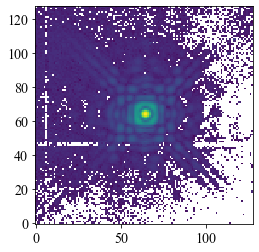

In [66]:
plt.imshow((img_sim)**0.25,interpolation='none')

In [67]:
# ls ../data/n8yj56010

In [68]:
# fits.getheader("../data/n8yj56010/n8yj56010_mos.fits.gz")

In [69]:
# a.plot_KPD()


computing colinearity map...
max colinearity found for sep = 170.29 mas and ang = 86.63 deg


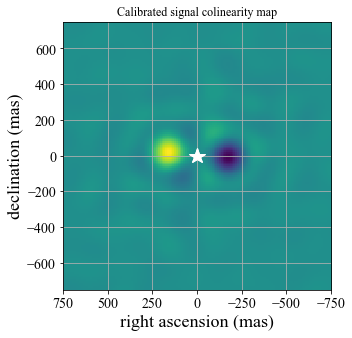

In [70]:
print("\ncomputing colinearity map...")
gsize = 150 # gsize x gsize grid
gstep = 10 # grid step in mas
xx, yy = np.meshgrid(
        np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
azim = -np.arctan2(xx, yy) * 180.0 / np.pi
dist = np.hypot(xx, yy) * gstep

#mmap = kpo1.kpd_binary_match_map(100, 10, mydata/myerr, norm=True)
mmap = a.kpd_binary_match_map(gsize, gstep, mydata, norm=True)
x0, y0 = np.argmax(mmap) % gsize, np.argmax(mmap) // gsize
print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
        dist[y0, x0], azim[y0, x0]))

f1 = plt.figure(figsize=(5,5))
ax1 = f1.add_subplot(111)
ax1.imshow(mmap, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax1.set_xlabel("right ascension (mas)")
ax1.set_ylabel("declination (mas)")
ax1.plot([0,0], [0,0], "w*", ms=16)
ax1.set_title("Calibrated signal colinearity map")
ax1.grid()
f1.set_tight_layout(True)
f1.canvas.draw()


In [71]:
from scipy.optimize import leastsq, minimize


def binary_model(params,kpo):
    u = kpo.kpi.UVC[:,0]
    v = kpo.kpi.UVC[:,1]
    wl = kpo.CWAVEL
    detpa = 0
    return(xara.core.cvis_binary_jax(u,v,wl, params, detpa))

def ben_binary_model_fit_residuals(params,kpo=a,index=0,obs="KERNEL",err=1.0):
    temp = binary_model(params,kpo)
    model = np.array(kpo.kpi.KPM).dot(np.angle(temp))
    error = mydata-model
    error /= (err)
    return np.array(error)

def ben_binary_model_fit_chi2(params):
    residuals = ben_binary_model_fit_residuals(params,kpo=a,index=0,obs="KERNEL",err=myerr)
    chi2 = np.sum(np.abs(residuals)**2)
    return chi2

from jax import jit

chi2_jac = jacrev(ben_binary_model_fit_chi2)
chi2_jac_np = lambda x:onp.array(jit(chi2_jac)(x))

def ben_binary_model_fit(p0,kpo=a,index=0,obs='KERNEL',err=myerr):
    soluce = leastsq(ben_binary_model_fit_residuals, 
                 p0, args=((kpo,index, obs,err)), full_output=1)
#     soluce = minimize(ben_binary_model_fit_chi2,p0,method='BFGS',jac=chi2_jac_np)
#     p1 = soluce['x'][0] # the best fit parameter vector (sep, P.A., contrast)
    
    
    return soluce


In [72]:
def get_chi2(addederror):
    return np.sum(((mydata - np.array(ker_theo))/np.sqrt(myerr**2+addederror**2))**2) / (1.0*a.kpi.nbkp)

from jax import grad

def add_error():
    def get_objective(addederror):
        return np.abs(get_chi2(addederror)-1.)
    jac = grad(get_objective)
    return minimize(get_objective,0.0025,method='BFGS')['x']



binary model fitting...
sep = 159.929016, ang=90.350314, con=22.674160 => chi2 = 0.439
correlation matrix of parameters
[[ 3.    0.01  0.11]
 [ 0.01  0.08 -0.02]
 [ 0.11 -0.02  0.02]]
Estimated Uncertainty
[1.73291263 0.29114757 0.153206  ]


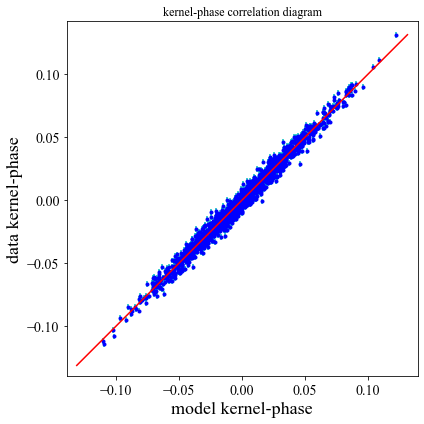

In [73]:
print("\nbinary model fitting...")
# p0 = params0 # good starting point
# p0 =  [dist[y0, x0], azim[y0, x0], mmap.max()] # good starting point
p0 = truth
p0[1] = np.mod(p0[1],360.)

wl = a.CWAVEL

# mfit = a.binary_model_fit(p0)
mfit = ben_binary_model_fit(p0,kpo=a,err=myerr)

p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)
# p1 = mfit['x']
p1[1] = np.mod(p1[1],360.)
# p1 = p0
# p1 = p0


cvis_b = xara.core.cvis_binary(
        a.kpi.UVC[:,0], a.kpi.UVC[:,1], wl, p1) # binary
ker_theo = a.kpi.KPM.dot(np.angle(cvis_b))

added_error = add_error()
this_error = np.sqrt(myerr**2+added_error**2)
mfit = ben_binary_model_fit(p0,kpo=a,err=this_error)
p2 = np.array(p1)#+np.sqrt(np.diag(mfit[1]))

cvis_b = xara.core.cvis_binary(
        a.kpi.UVC[:,0], a.kpi.UVC[:,1], wl, p2) # binary
ker_theo = a.kpi.KPM.dot(np.angle(cvis_b))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.errorbar(ker_theo, mydata, yerr=myerr, fmt="none", ecolor='c')
ax.plot(ker_theo, mydata, 'b.')
mmax = (np.abs(mydata).max())
ax.plot([-mmax,mmax],[-mmax,mmax], 'r')
ax.set_ylabel("data kernel-phase")
ax.set_xlabel("model kernel-phase")
ax.set_title('kernel-phase correlation diagram')
ax.axis("equal")
# ax.axis([-11, 11, -11, 11])
fig.set_tight_layout(True)

if myerr is not None:
        chi2 = np.sum(((mydata - ker_theo)/(this_error))**2) / a.kpi.nbkp
else:
        chi2 = np.sum(((mydata - ker_theo))**2) / a.kpi.nbkp

print("sep = %3f, ang=%3f, con=%3f => chi2 = %.3f" % (p1[0], p1[1], p1[2], chi2))
print("correlation matrix of parameters")
# hess_inv = mfit['hess_inv']
hess_inv = mfit[1]
print(np.round(hess_inv, 2))
print('Estimated Uncertainty')
print(np.sqrt(np.diag(hess_inv)))

In [74]:
def negative_log_posterior(params):
    temp = binary_model(params,a)
    model = np.array(a.kpi.KPM).dot(np.angle(temp))
    error = mydata-model
    error /= (this_error)
    chi2 = np.sum((error)**2)

    return chi2

def grad_negative_log_posterior(params):
    return -1*jacrev(negative_log_posterior)(params)

def approx_covariance_matrix(params):
    # evaluate the covariance matrix of the approximate normal
    return np.linalg.inv(hessian(negative_log_posterior)(params))


In [75]:
covar = approx_covariance_matrix(1.0*np.array(p1))
uncertainty = (np.sqrt(np.diag(covar)))
print('Covariance matrix',covar)
print('Sigma',uncertainty)

Covariance matrix [[ 1.52089833  0.04100779  0.04870361]
 [ 0.04100779  0.03891409 -0.00838443]
 [ 0.04870361 -0.00838443  0.01081048]]
Sigma [1.23324707 0.19726656 0.10397348]


### Now do a cube

In [42]:
results = []
uncertainties = []

# myerr = np.ones_like(mydata)*0.01*(onp.nanmedian(np.abs(mydata)))
seps_in = np.linspace(90,500,20)
calib = np.median(calibrators,axis=0)

for j, sep_in in enumerate(tqdm(seps_in)):
#     img = preprocess_like(tgt_cube[:,:,j],b)
    
    truth = [sep_in,90,25]
    binary = sim_binary(cal,*truth,43.1)
    img_sim = preprocess_like(binary,b)
    a = c.copy()
    
    a.extract_KPD_single_frame(
    img_sim, pscale, wl, recenter=True,method='LDFT1')

    a.kpi.name = "simulation" #  # labels the data
#     calib  = pca.inverse_transform(pca.transform(a.KPDT[0]))[0]
    mydata = a.KPDT[0][0]-calib
    
    p0 = truth
    p0[1] = np.mod(p0[1],360.)

    # mfit = a.binary_model_fit(p0)
    mfit = ben_binary_model_fit(p0,kpo=a)
    
    cvis_b = xara.core.cvis_binary(
        a.kpi.UVC[:,0], a.kpi.UVC[:,1], wl, p2) # binary
    ker_theo = a.kpi.KPM.dot(np.angle(cvis_b))

    if myerr is not None:
        chi2 = np.sum(((mydata - ker_theo)/(this_error))**2) / a.kpi.nbkp
    else:
        chi2 = np.sum(((mydata - ker_theo))**2) / a.kpi.nbkp

    added_error = add_error()
    this_error = np.sqrt(myerr**2+added_error**2)

    p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)
    p1[1] = np.mod(p1[1],360.)
    results.append(p1)

    def negative_log_posterior(params):
        temp = binary_model(params,a)
        model = np.array(a.kpi.KPM).dot(np.angle(temp))
        error = mydata-model
        error /= (this_error)
        chi2 = np.sum((error)**2)
        return chi2

    def approx_covariance_matrix(params):
        # evaluate the covariance matrix of the approximate normal
        return np.linalg.inv(hessian(negative_log_posterior)(params))

    covar = approx_covariance_matrix(1.0*np.array(p1))
    uncertainties.append(np.sqrt(np.diag(covar)))

seps_out = np.array([result[0] for result in results])
thetas_out = np.array([result[1] for result in results])
cons_out = np.array([result[2] for result in results])

dseps_out = np.array([uncertainty[0] for uncertainty in uncertainties])
dthetas_out = np.array([uncertainty[1] for uncertainty in uncertainties])
dcons_out = np.array([uncertainty[2] for uncertainty in uncertainties])

100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


In [76]:
pscale

43.1

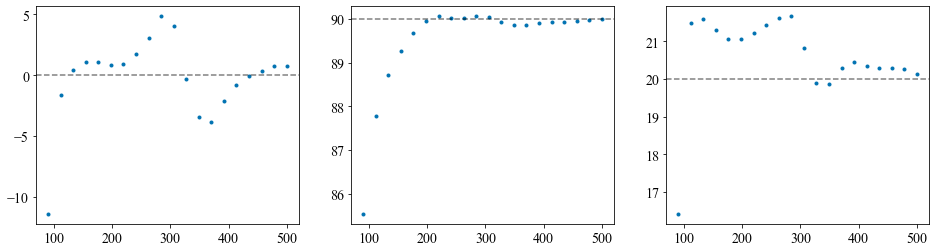

In [49]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16.0,4.0))
inds = np.arange(len(seps_in))

ax1.plot(seps_in,seps_out-seps_in,'.')
ax1.axhline(0,color='k',linestyle='--',alpha=0.5)
ax1.errorbar(seps_in,seps_out-seps_in,yerr=dseps_out,ls='none',color=colours[0])

# ax1.plot(seps_in,seps_in,'--k',alpha=0.5)

ax2.plot(seps_in,thetas_out,'.')
ax2.axhline(truth[1],color='k',linestyle='--',alpha=0.5)
ax2.errorbar(seps_in,thetas_out,yerr=dthetas_out,ls='none',color=colours[0])

ax3.plot(seps_in,cons_out,'.')
ax3.errorbar(seps_in,dcons_out,yerr=dcons_out,ls='none',color=colours[0])

ax3.axhline(truth[2],color='k',linestyle='--',alpha=0.5)

### Now try Peter's

In [79]:
myerr = np.ones_like(mydata)*0.01*(onp.nanmedian(np.abs(mydata)))
myerr = np.std(calibrators,axis=0)
calib = np.median(calibrators,axis=0)
chi2s = []

for do_cal in [False,True]:
    results = []
    uncertainties = []
    ssteps, thsteps = [], []
    # plt.plot(0,0,'*')
    for i in range(0,20):
        step=np.array((-0.17,0.28))*i + np.array((3.0,2.0))
    #     print(step)
        sep_step = 43.1 * (np.hypot(*step))
        th_step = 180./np.pi*(np.angle(step[1]-1.j*step[0]))
    #     plt.plot(step[0],step[1],'.')

        ssteps.append(sep_step)
        thsteps.append(th_step)
    ssteps = np.array(ssteps)
    thsteps = np.mod(np.array(thsteps),360)
    # plt.axis('square')

    for j in tqdm(range(20)):
        img = preprocess_like(tgt_cube[:,:,j],b)

        a = c.copy()

        a.extract_KPD_single_frame(
        img, pscale, wl, recenter=True,method='LDFT1')

        a.kpi.name = "simulation" #  # labels the data
        if do_cal:
            mydata = a.KPDT[0][0]-calib#b.KPDT[0][0]
        else:
            mydata = a.KPDT[0][0]

    #     print("\ncomputing colinearity map...")
    #     gsize = 100 # gsize x gsize grid
    #     gstep = 5 # grid step in mas
    #     xx, yy = np.meshgrid(
    #             np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
    #     azim = -np.arctan2(xx, yy) * 180.0 / np.pi
    #     dist = np.hypot(xx, yy) * gstep

    # #     mmap = kpo1.kpd_binary_match_map(100, 10, mydata/myerr, norm=True)
    #     mmap = a.kpd_binary_match_map(gsize, gstep, mydata, norm=True)
    #     x0, y0 = np.argmax(mmap) % gsize, np.argmax(mmap) // gsize
    #     print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
    #             dist[y0, x0], azim[y0, x0]))

    #     p0 =  [dist[y0, x0], azim[y0, x0], mmap.max()] # good starting point
        p0 = [ssteps[j], thsteps[j],20]
        p0[1] = np.mod(p0[1],360.)
    #     p0[0] = 150+j*10

        # mfit = a.binary_model_fit(p0)
        mfit = ben_binary_model_fit(p0,kpo=a)

        p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)
        p1[1] = np.mod(p1[1],360.)
        p1[0] = np.abs(p1[0])
        results.append(p1)

        cvis_b = xara.core.cvis_binary(a.kpi.UVC[:,0], a.kpi.UVC[:,1], wl, p1) # binary
        ker_theo = a.kpi.KPM.dot(np.angle(cvis_b))

        def get_chi2(addederror):
            return np.sum(((mydata - np.array(ker_theo))/np.sqrt(myerr**2+addederror**2))**2) / (1.0*a.kpi.nbkp)
        chi2 = get_chi2(0)
        chi2s.append(chi2)

        if chi2 > 1.0:
            from jax import grad

            def add_error():
                def get_objective(addederror):
                    return np.abs(get_chi2(addederror)-1.)
                jac = grad(get_objective)
                return minimize(get_objective,0.0025,method='BFGS')['x']

            added_error = add_error()
            this_error = np.sqrt(myerr**2+added_error**2)
        else:
            this_error = myerr 
        
        def negative_log_posterior(params):
            temp = binary_model(params,a)
            model = np.array(a.kpi.KPM).dot(np.angle(temp))
            error = mydata-model
            error /= (this_error)
            chi2 = np.sum((error)**2)

            return chi2

        def grad_negative_log_posterior(params):
            return -1*jacrev(negative_log_posterior)(params)

        def approx_covariance_matrix(params):
            # evaluate the covariance matrix of the approximate normal
            return np.linalg.inv(hessian(negative_log_posterior)(params))

        covar = approx_covariance_matrix(1.0*np.array(p1))
        uncertainties.append(np.sqrt(np.diag(covar)))
    print('chi2s:',(np.array(chi2s)))
    
    if do_cal:
        seps_out_nocal = np.array([result[0] for result in results])
        thetas_out_nocal = np.array([result[1] for result in results])
        cons_out_nocal = np.array([result[2] for result in results])
        
        dseps_out_nocal = np.array([uncertainty[0] for uncertainty in uncertainties])
        dthetas_out_nocal = np.array([uncertainty[1] for uncertainty in uncertainties])
        dcons_out_nocal = np.array([uncertainty[2] for uncertainty in uncertainties])

    else:
        seps_out = np.array([result[0] for result in results])
        thetas_out = np.array([result[1] for result in results])
        cons_out = np.array([result[2] for result in results])
        dseps_out = np.array([uncertainty[0] for uncertainty in uncertainties])
        dthetas_out = np.array([uncertainty[1] for uncertainty in uncertainties])
        dcons_out = np.array([uncertainty[2] for uncertainty in uncertainties])



100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


chi2s: [0.24539524 0.2374643  0.25777845 0.2975383  0.31972744 0.32132743
 0.31127022 0.29864425 0.29689954 0.30311256 0.30764077 0.30967736
 0.31121266 0.3135038  0.31673685 0.32092527 0.32652261 0.33340752
 0.33926398 0.34156067]


100%|██████████| 20/20 [00:36<00:00,  1.84s/it]

chi2s: [0.24539524 0.2374643  0.25777845 0.2975383  0.31972744 0.32132743
 0.31127022 0.29864425 0.29689954 0.30311256 0.30764077 0.30967736
 0.31121266 0.3135038  0.31673685 0.32092527 0.32652261 0.33340752
 0.33926398 0.34156067 0.4193975  0.39659404 0.37940668 0.37947139
 0.38376025 0.37185251 0.34149335 0.3041075  0.27400061 0.25688345
 0.24907829 0.24777423 0.2520855  0.26156316 0.28577879 0.32869463
 0.37927769 0.42239816 0.44477137 0.44614004]


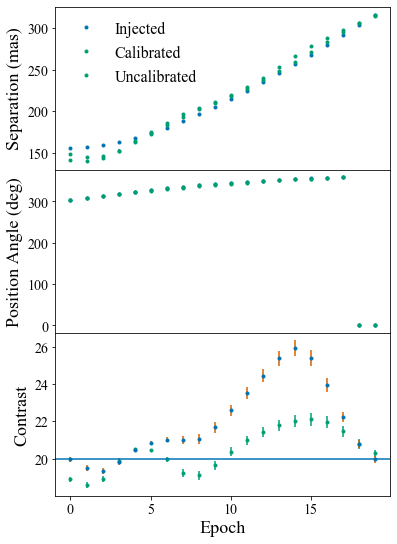

In [80]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(6,9),sharex=True)
inds = np.arange(len(ssteps))
ax1.plot(ssteps,'.',label='Injected')
ax1.plot(seps_out,'.',label='Calibrated',color=colours[1])
ax1.errorbar(inds,seps_out,yerr=dseps_out,ls='none',color=colours[1])
ax1.plot(seps_out_nocal,'.',label='Uncalibrated')
ax1.errorbar(inds,seps_out_nocal,yerr=dseps_out_nocal,ls='none',color=colours[2])
ax1.set_ylabel('Separation (mas)')
# ax1.plot(seps_in,seps_in,'--k',alpha=0.5)
ax1.legend(fontsize=16,frameon=False)
ax1.set_xticks([])

ax2.plot(thsteps,'.')
# ax2.plot(thetas_out,'.')
# ax2.plot(thetas_out_nocal,'.')
ax2.plot(thetas_out,'.',label='Calibrated',color=colours[1])
ax2.errorbar(inds,thetas_out,yerr=dthetas_out,ls='none',color=colours[1])
ax2.plot(thetas_out_nocal,'.',label='Uncalibrated')
ax2.errorbar(inds,thetas_out_nocal,yerr=dthetas_out_nocal,ls='none',color=colours[2])

ax2.set_ylabel('Position Angle (deg)')
ax2.set_xticks([])

# ax2.axhline(truth[1],color='k',linestyle='--',alpha=0.5)
# ax3.plot(cons_out,'.',color=colours[1])
# ax3.plot(cons_out_nocal,'.',color=colours[2])
ax3.plot(cons_out,'.',label='Calibrated',color=colours[1])
ax3.errorbar(inds,cons_out,yerr=dcons_out,ls='none',color=colours[1])
ax3.plot(cons_out_nocal,'.',label='Uncalibrated')
ax3.errorbar(inds,cons_out_nocal,yerr=dcons_out_nocal,ls='none',color=colours[2])
ax3.axhline(20)
ax3.set_ylabel('Contrast')
ax3.set_xlabel('Epoch')
ax2.set_xticks(np.arange(20)[::5])

plt.subplots_adjust(wspace=0, hspace=0)

# ax3.axhline(truth[2],color='k',linestyle='--',alpha=0.5)
# plt.savefig('hare_hounds.png',bbox_inches='tight')

In [ ]:
# paramlimits=[p1[0]*0.9,p1[0]*1.1,0,360,15,30.]

# def binary_model(params,kpo):
#     u = kpo.kpi.UVC[:,0]
#     v = kpo.kpi.UVC[:,1]
#     wl = kpo.CWAVEL
#     detpa = 0
#     return(xara.core.cvis_binary_jax(u,v,wl, params, detpa))

# @jit
# def kp_loglikelihood(params,kpo):
#     temp = binary_model(params,kpo)
#     model = np.array(kpo.kpi.KPM).dot(np.angle(temp))
#     error = mydata-model
#     error /= (myerr)
#     chi2 = -np.sum((error)**2)
#     return chi2 

# def negative_log_posterior(params):
#     temp = binary_model(params,a)
#     model = np.array(a.kpi.KPM).dot(np.angle(temp))
#     error = mydata-model
#     error /= (myerr)
#     chi2 = np.sum((error)**2)

#     return chi2

# def grad_negative_log_posterior(params):
#     return -1*jacrev(negative_log_posterior)(params)

# @jit
# def approx_covariance_matrix(params):
#     # evaluate the covariance matrix of the approximate normal
#     return np.linalg.inv(hessian(negative_log_posterior)(params))


# def lnprior(params):
#     if paramlimits[0] < params[0] < paramlimits[1] and paramlimits[2] < params[1] < paramlimits[3] and paramlimits[4] < params[2] < paramlimits[5]:
#         return -np.log(params[0]) -np.log(params[2])
#     return -np.inf

# def lnprob(params,kpo):
#     return lnprior(params) + kp_loglikelihood(params,kpo)

# ndim=3
# nwalkers=100
# plot=False
# burnin=100
# nsteps=1000

# import time


In [ ]:
# np.sqrt(np.diag(approx_covariance_matrix(1.0*np.array(p1))))

In [ ]:
# import emcee

# ivar = np.array(p1)  # initial parameters for model-fit

# ball = np.array([ivar + 0.01*ivar*onp.random.rand(ndim) for i in range(nwalkers)]) # initialise walkers in a ball

# print('Running emcee now!')

# t0 = time.time()

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[a])

# # burn in
# pos,prob,state = sampler.run_mcmc(ball, burnin)
# sampler.reset()

# t1 = time.time()

# print('Burnt in! Took %.3f seconds' %(t1-t0))


In [ ]:
# # restart
# sampler.run_mcmc(pos,nsteps)

# tf = time.time()

# print('Time elapsed = %.3f s' %(tf-t0))

# seps = sampler.flatchain[:,0]
# ths = sampler.flatchain[:,1]

# meansep = np.mean(seps)
# dsep = np.std(seps)

# meanth = np.mean(ths)
# dth = np.std(ths)

# cs = sampler.flatchain[:,2]
# bestcon = np.mean(cs)
# conerr = np.std(cs)

# print('Separation %.3f pm %.3f mas' % (meansep,dsep))
# print('Position angle %.3f pm %.3f deg' % (meanth,dth))
# print('Contrast at',wl,'um %.3f pm %.3f' % (bestcon,conerr))


In [ ]:
# import corner

In [ ]:
# # Plot it.
# figure = corner.corner(sampler.flatchain, labels=[r"$\rho$", r"$\theta$", r"$c$",],
#                        quantiles=[0.16, 0.5, 0.84],
#                        show_titles=True, title_kwargs={"fontsize": 12},truths=p0)


In [ ]:
p0